In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
df = pd.read_csv("../../data/data_adjustmented.csv")

In [10]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
# Time series visualization with Plotly Express
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# สร้าง time series data
ts_bts_data = pd.Series(df['รถไฟฟ้า BTS'].values, 
                   index=pd.date_range(start='2020-01-01', 
                                     periods=len(df), 
                                     freq='D'))

# แสดงข้อมูล 5 แถวแรก
print("First 5 rows:")
print(ts_bts_data.head())

# แสดงข้อมูลเชิงสถิติพื้นฐาน
print("\nBasic statistics:")
print(ts_bts_data.describe())

# เตรียมข้อมูลสำหรับ plotly
df_plot = pd.DataFrame({
    'วันที่': ts_bts_data.index,
    'ราง': ts_bts_data.values
})

# เพิ่มข้อมูลการวิเคราะห์
df_plot['เดือน'] = df_plot['วันที่'].dt.month
df_plot['วันในสัปดาห์'] = df_plot['วันที่'].dt.dayofweek
df_plot['ปี'] = df_plot['วันที่'].dt.year

# กำหนดสีธีม
colors = {
    'primary': '#69247C',
    'secondary': '#DA498D', 
    'accent': '#FAC67A',
    'background': '#2C3E50'
}

# สร้าง subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        '<b>การเดินทางด้วยรถรางไฟฟ้ารายวัน</b>',
        '<b>การกระจายตัวของข้อมูล</b>',
        '<b>ค่าเฉลี่ยรายเดือน</b>',
        '<b>ค่าเฉลี่ยรายวัน (วันในสัปดาห์)</b>'
    ],
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]],
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

# 1. Time Series หลัก
fig.add_trace(
    go.Scatter(
        x=df_plot['วันที่'],
        y=df_plot['ราง'],
        mode='lines',
        name='จำนวนผู้โดยสาร',
        line=dict(color=colors['primary'], width=1.5),
        hovertemplate='<b>%{x}</b><br>จำนวนผู้โดยสาร: %{y:,.0f} คน<extra></extra>'
    ),
    row=1, col=1
)

# เพิ่ม trend line
z = np.polyfit(range(len(ts_bts_data)), ts_bts_data.values, 1)
trend_line = z[0] * np.arange(len(ts_bts_data)) + z[1]
fig.add_trace(
    go.Scatter(
        x=df_plot['วันที่'],
        y=trend_line,
        mode='lines',
        name=f'Trend: {z[0]:.2f}',
        line=dict(color=colors['secondary'], width=2, dash='dash'),
        hovertemplate='<b>Trend</b><br>%{y:,.0f} คน<extra></extra>'
    ),
    row=1, col=1
)

# 2. Histogram
fig.add_trace(
    go.Histogram(
        x=df_plot['ราง'],
        nbinsx=50,
        name='การกระจายตัว',
        marker_color=colors['accent'],
        opacity=0.7,
        hovertemplate='ช่วง: %{x:,.0f}<br>ความถี่: %{y}<extra></extra>'
    ),
    row=1, col=2
)

# เพิ่มเส้นค่าเฉลี่ยและค่ากลาง
mean_val = ts_bts_data.mean()
median_val = ts_bts_data.median()

fig.add_vline(
    x=mean_val, 
    line=dict(color='red', dash='dash', width=2),
    annotation_text=f'Mean: {mean_val:,.0f}',
    row=1, col=2
)

fig.add_vline(
    x=median_val,
    line=dict(color='orange', dash='dash', width=2), 
    annotation_text=f'Median: {median_val:,.0f}',
    row=1, col=2
)

# 3. Monthly pattern
monthly_data = df_plot.groupby('เดือน')['ราง'].mean()
month_names = ['ม.ค.', 'ก.พ.', 'มี.ค.', 'เม.ย.', 'พ.ค.', 'มิ.ย.',
               'ก.ค.', 'ส.ค.', 'ก.ย.', 'ต.ค.', 'พ.ย.', 'ธ.ค.']

fig.add_trace(
    go.Bar(
        x=month_names,
        y=monthly_data.values,
        name='ค่าเฉลี่ยรายเดือน',
        marker_color=colors['secondary'],
        opacity=0.8,
        text=[f'{v:,.0f}' for v in monthly_data.values],
        textposition='outside',
        hovertemplate='<b>%{x}</b><br>ค่าเฉลี่ย: %{y:,.0f} คน<extra></extra>'
    ),
    row=2, col=1
)

# 4. Weekly pattern
weekly_data = df_plot.groupby('วันในสัปดาห์')['ราง'].mean()
day_names = ['จันทร์', 'อังคาร', 'พุธ', 'พฤหัสบดี', 'ศุกร์', 'เสาร์', 'อาทิตย์']
bar_colors = [colors['primary'] if i < 5 else colors['accent'] for i in range(7)]

fig.add_trace(
    go.Bar(
        x=day_names,
        y=weekly_data.values,
        name='ค่าเฉลี่ยรายวัน',
        marker_color=bar_colors,
        opacity=0.8,
        text=[f'{v:,.0f}' for v in weekly_data.values],
        textposition='outside',
        hovertemplate='<b>%{x}</b><br>ค่าเฉลี่ย: %{y:,.0f} คน<extra></extra>'
    ),
    row=2, col=2
)

# ปรับแต่งกราฟ
fig.update_layout(
    title={
        'text': 'การวิเคราะห์ข้อมูลการเดินทางด้วยรถรางไฟฟ้า',
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=28, color=colors['background'])
    },
    showlegend=False,
    height=900,
    width=1400,
    template='plotly_white',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# ปรับแต่ง axes
for row in range(1, 3):
    for col in range(1, 3):
        fig.update_xaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='#E5E8E8',
            tickfont=dict(size=11),
            row=row, col=col
        )
        fig.update_yaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='#E5E8E8',
            tickfont=dict(size=11),
            tickformat=',d',
            row=row, col=col
        )

# ปรับแต่งชื่อแกน
fig.update_xaxes(title_text='วันที่', title_font=dict(size=14), row=1, col=1)
fig.update_xaxes(title_text='จำนวนผู้โดยสาร (คน)', title_font=dict(size=14), row=1, col=2)
fig.update_xaxes(title_text='เดือน', title_font=dict(size=14), row=2, col=1)
fig.update_xaxes(title_text='วันในสัปดาห์', title_font=dict(size=14), row=2, col=2)

fig.update_yaxes(title_text='จำนวนผู้โดยสาร (คน)', title_font=dict(size=14), row=1, col=1)
fig.update_yaxes(title_text='ความถี่', title_font=dict(size=14), row=1, col=2)
fig.update_yaxes(title_text='จำนวนผู้โดยสารเฉลี่ย (คน)', title_font=dict(size=14), row=2, col=1)
fig.update_yaxes(title_text='จำนวนผู้โดยสารเฉลี่ย (คน)', title_font=dict(size=14), row=2, col=2)

# แสดงกราฟ
fig.show()

# แสดงข้อมูลสถิติเพิ่มเติม
print(f"\n📊 สถิติเพิ่มเติม:")
print(f"• ค่าสูงสุด: {ts_bts_data.max():,.0f} คน (วันที่ {ts_bts_data.idxmax().strftime('%Y-%m-%d')})")
print(f"• ค่าต่ำสุด: {ts_bts_data.min():,.0f} คน (วันที่ {ts_bts_data.idxmin().strftime('%Y-%m-%d')})")
print(f"• ค่าเฉลี่ย: {ts_bts_data.mean():,.0f} คน")
print(f"• ส่วนเบี่ยงเบนมาตรฐาน: {ts_bts_data.std():,.0f} คน")
print(f"• ค่ากลาง: {ts_bts_data.median():,.0f} คน")
print(f"• ช่วงข้อมูล: {ts_bts_data.max() - ts_bts_data.min():,.0f} คน")
print(f"• ค่าเฉลี่ยวันธรรมดา: {weekly_data[:5].mean():,.0f} คน")
print(f"• ค่าเฉลี่ยวันหยุดสุดสัปดาห์: {weekly_data[5:].mean():,.0f} คน")

First 5 rows:
2020-01-01    461400
2020-01-02    720500
2020-01-03    782100
2020-01-04    574400
2020-01-05    503000
Freq: D, dtype: int64

Basic statistics:
count    2.073000e+03
mean     5.768197e+05
std      2.289784e+05
min      5.610000e+04
25%      4.058780e+05
50%      6.031550e+05
75%      7.837390e+05
max      1.630934e+06
dtype: float64



📊 สถิติเพิ่มเติม:
• ค่าสูงสุด: 1,630,934 คน (วันที่ 2024-09-11)
• ค่าต่ำสุด: 56,100 คน (วันที่ 2020-04-12)
• ค่าเฉลี่ย: 576,820 คน
• ส่วนเบี่ยงเบนมาตรฐาน: 228,978 คน
• ค่ากลาง: 603,155 คน
• ช่วงข้อมูล: 1,574,834 คน
• ค่าเฉลี่ยวันธรรมดา: 630,143 คน
• ค่าเฉลี่ยวันหยุดสุดสัปดาห์: 443,413 คน


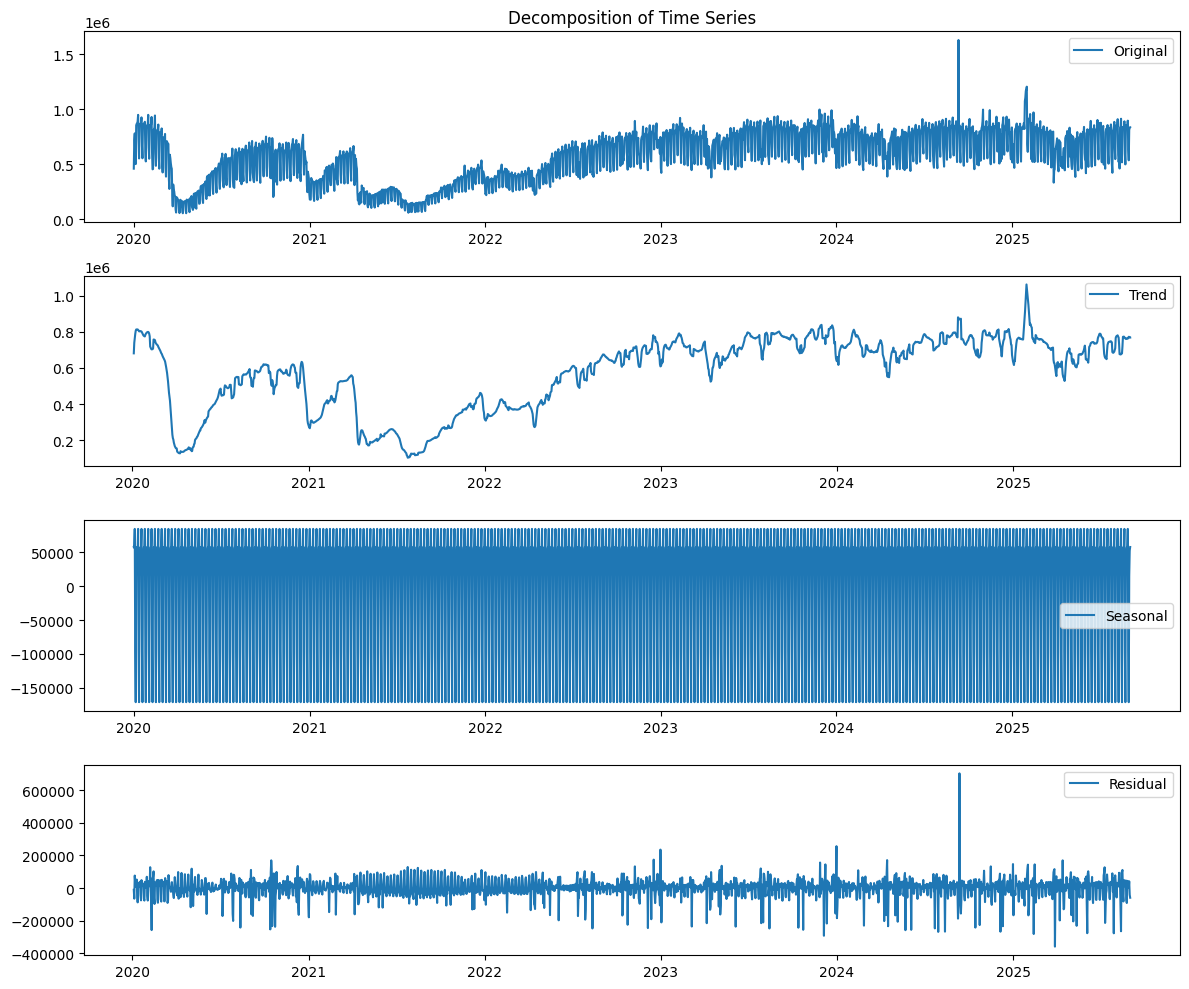

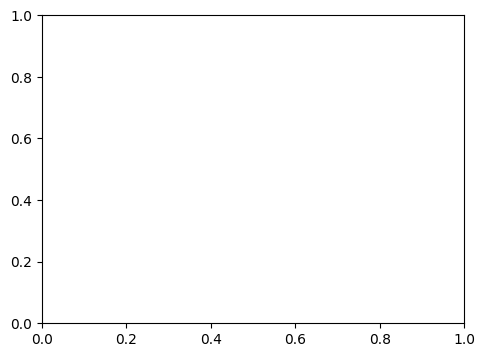

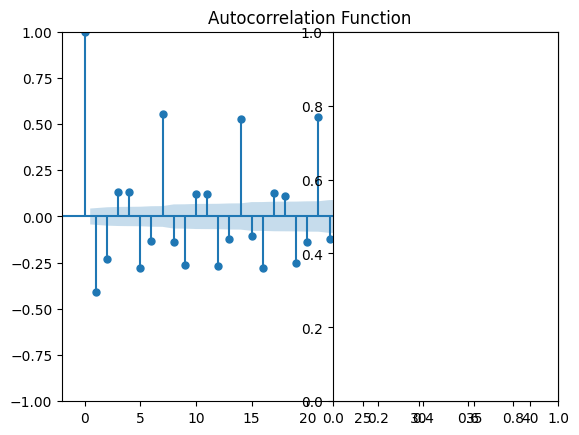

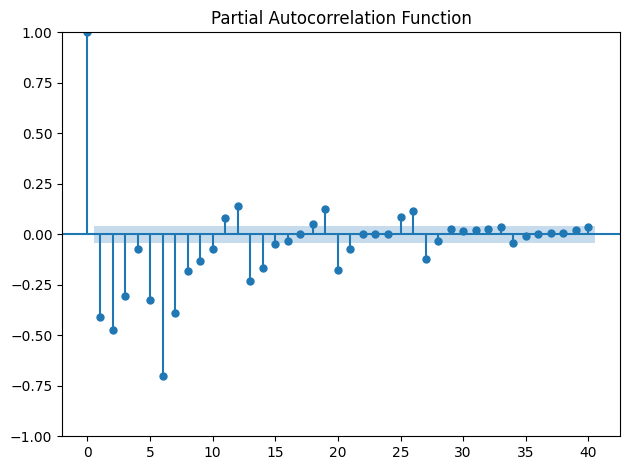


Augmented Dickey-Fuller Test:
ADF Statistic: -17.69764107643243
p-value: 3.548750329169313e-30
Critical values:
	1%: -3.4335532932197967
	5%: -2.8629550592036455
	10%: -2.5675233142202276


In [12]:
# 1. การวิเคราะห์แนวโน้มและความผันผวน
from statsmodels.tsa.seasonal import seasonal_decompose

# # Decompose time series
decomposition = seasonal_decompose(ts_bts_data, period=7)  # period=7 for weekly seasonality

# Plot decomposition
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(ts_bts_data, label='Original')
plt.legend()
plt.title('Decomposition of Time Series')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

# ACF และ PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts_bts_diff = np.diff(ts_bts_data, n=2)  
# plt.figure(figsize=(12, 10))
# plt.subplot(411)
# plt.plot(ts_road_diff, label='Original')
# plt.legend()
# plt.title('Differencing of Time Series')


plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_acf(ts_bts_diff, lags=40, title='Autocorrelation Function')

plt.subplot(122)
plot_pacf(ts_bts_diff, lags=40, title='Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

# 5. Checking stationarity
from statsmodels.tsa.stattools import adfuller

print('\nAugmented Dickey-Fuller Test:')
result = adfuller(ts_bts_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

In [ ]:

train, test = ts_bts_data[:2066], ts_bts_data[2066:]
print(len(train), len(test))


2066 7


In [18]:
# Import SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

P, D, Q, m = 3, 2, 3, 7  # Seasonal parameters 

# สร้างและ fit SARIMA model
model_sarima = SARIMAX(
    train,
    order=(P, D, Q),
    seasonal_order=(P, D, Q, m),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_sarima = model_sarima.fit()

d:\PSU\241-353\Mini_Project\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




SARIMA Model Evaluation Metrics:
RMSE: 53628.4614
MAPE: 6.4041%


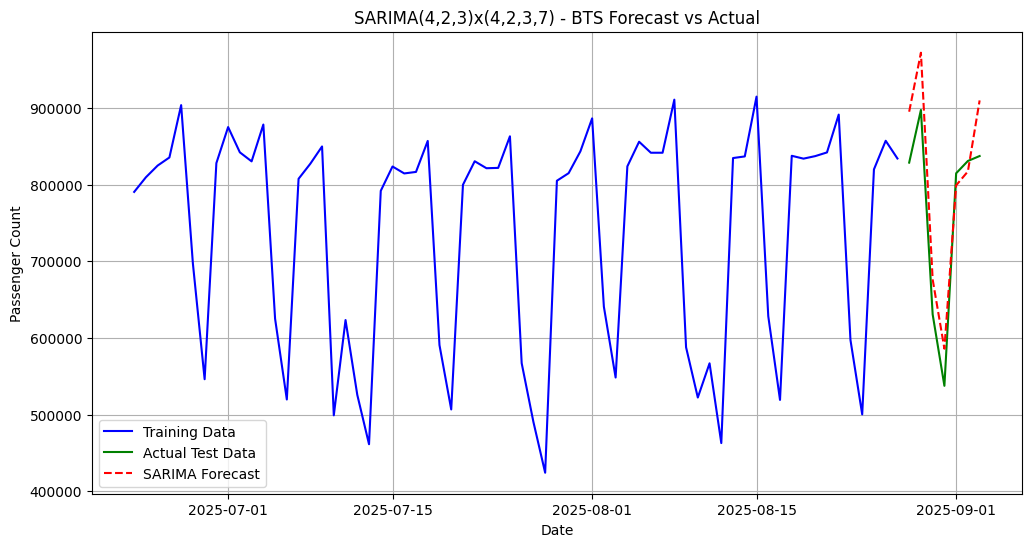

In [17]:
# ทำนายค่าสำหรับชุดทดสอบ
forecast_sarima = results_sarima.forecast(steps=len(test))

# คำนวณค่าความผิดพลาด
mae_sarima = mean_absolute_error(test, forecast_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test, forecast_sarima))
mape_sarima = mape(test, forecast_sarima)

print("\nSARIMA Model Evaluation Metrics:")
print(f"RMSE: {rmse_sarima:.4f}")
print(f"MAPE: {mape_sarima:.4f}%")

# สร้างกราฟแสดงผลการทำนาย
plt.figure(figsize=(12, 6))
plt.plot(ts_bts_data[2000:2066].index, ts_bts_data[2000:2066], label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test Data', color='green')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', color='red', linestyle='--')

plt.title(f'SARIMA({P},{D},{Q})x({P},{D},{Q},{m}) - BTS Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True)
plt.show()

